# **ACM India Summer School 2025: Vision-Language Models Tutorial**
- - -
Authors:

- Shataxi Dubey (shataxi.dubey@iitgn.ac.in)
- Devansh Lodha (devansh.lodha@iitgn.ac.in)

## **Section 0: Set Up**
Welcome to the Vision Language Models tutorial!

If you're reading this then you better run the two cells below!

In [1]:
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install fsspec==2023.9.2
!pip install transformers==4.51.3
!pip install --no-deps unsloth
!pip install supervision

In [2]:
# Standard library imports
import os
import gc

# Core ML/DL imports
import torch

# Helper functions
from PIL import Image
import requests
from matplotlib import pyplot as plt
import gdown
import zipfile
import json

from datasets import Dataset, Image as HFImage # Hugging Face Dataset and Image feature
import supervision as sv
import numpy as np

# Unsloth
from unsloth import FastVisionModel
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

from transformers import AutoTokenizer, pipeline
from transformers import CLIPProcessor, CLIPModel


def display_image(image_url_or_path, _ax=None):
    # Handle PIL Image object
    if hasattr(image_url_or_path, 'size'):
        image = image_url_or_path
    # Handle URL
    elif isinstance(image_url_or_path, str) and image_url_or_path.startswith("http"):
        response = requests.get(image_url_or_path, stream=True)
        image = Image.open(response.raw)
    # Handle file path
    else:
        image = Image.open(image_url_or_path)

    if _ax is None:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        _ax.imshow(image)
        _ax.axis('off')

    return image

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## **Section 1: The "Language" in VLMs - Words, Meaning, and Sequences**

### **How Can Computers Understand Language?**
They need to:
1. Convert words into a numerical format that models can process.
2. Capture the relationships between words in a sequence.
3. Process sentences of different lengths.

### **Background and Evolution**

#### **1. Word Embeddings**
A breakthrough was learning dense vector representations (embeddings) for words, where similar words have similar vector representations in a high-dimensional space. This captured semantic relationships (e.g., "king" - "man" + "woman" ≈ "queen").

<center>
<img src="https://drive.google.com/uc?export=view&id=1GUOl5TtlrDfY8wj-XaqNqLZpg94uqSHr" width="500">
</center>

#### **2. RNNs and LSTMs**
Recurrent Neural Networks (RNNs) were designed to process sequences by maintaining a "memory" (hidden state) of where and what they've seen so far.

Standard RNNs struggled to remember information from many steps ago in long sentences (the "vanishing gradient" problem).

LSTMs introduced a memory cell with "gates" that could learn to retain or forget information over longer periods, making them much better at handling long-range dependencies in text.

#### **3. Seq2Seq**
Translating a sentence from one language to another (Sequence-to-Sequence or Seq2Seq). Early approaches used an RNN (the "encoder") to read the input sentence and condense its entire meaning into a single, fixed-size vector. Another RNN (the "decoder") would then generate the translation from this one summary vector.

Squeezing all the information from a long, complex sentence into one small vector was a major bottleneck.

#### **4. Attention!**
Instead of forcing the decoder to rely on a single summary vector, at each step of generating an output word, the decoder could "look back" at the entire input sentence and decide which input words were most relevant for predicting the current output word. It would then use a weighted combination of these relevant input word representations.

This was a game-changer! It allowed models to handle much longer sentences more effectively and significantly improved performance on tasks like machine translation.

#### **5. The Transformer: "Attention Is All You Need"**
If attention is so good at identifying relevant context, can we build a powerful sequence model using only attention, without the sequential processing of RNNs/LSTMs?

**Self-Attention:** Allows every word in a sentence to directly look at and weigh the importance of every other word in the same sentence.

**Multi-Head Attention:** Performs several self-attention operations in parallel, allowing the model to focus on different types of relationships or "representation subspaces" simultaneously. One head could identify who did something, while another focuses on when it happened

**Positional Encodings:** To make up for the lack of RNNs (which naturally handles order), Transformers add information about the position of words in the sequence directly to their embeddings.

**Parallel Processing:** Because it didn't rely on step-by-step recurrent processing, the Transformer could process all words in a sequence simultaneously. (faster to train on GPUs/TPUs!).

<center>
<img src="https://drive.google.com/uc?export=view&id=1gKHvcOpVZPDXoKlnGMZd3b6Txk9R8e8V" width="500">
</center>

The Transformer revolutionized NLP and enabled the development of extremely large and powerful language models (like BERT, GPT) and its a **foundational piece** for many of the Vision-Language Models we'll be exploring.

##### **Hands-on: Transformers for Text - Tokenization & Generation**
Let's quickly see how Transformers handle text. We'll:
- Tokenize a sentence
- Do a tiny text generation with a small pre-trained model.

*Note: The first time you run the code below, it will download a model and tokenizer from Hugging Face. This is normal.*

In [4]:
# Load a small tokenizer & model (GPT-2)
nlp_model_name = "openai-community/gpt2"
tokenizer_nlp = AutoTokenizer.from_pretrained(nlp_model_name)
text_generator = pipeline("text-generation", model=nlp_model_name, tokenizer=tokenizer_nlp, max_new_tokens=10)

# Tokenization
my_sentence = "ACM Summer Schools 2025" #@param {type:"string"}
print(f"Original: '{my_sentence}'")

encoded_ids = tokenizer_nlp.encode(my_sentence)
print(f"Token IDs: {encoded_ids}")

# Convert IDs to their string representations (tokens)
tokens = tokenizer_nlp.convert_ids_to_tokens(encoded_ids)
print(f"Tokens: {tokens}")

decoded_sentence = tokenizer_nlp.decode(encoded_ids)
print(f"Decoded: '{decoded_sentence}'")

# Text Generation
prompt = "What is VLM?" #@param {type:"string"}
generated_output = text_generator(prompt)
print(f"\nPrompt: '{prompt}...'")
print(f"Generated: '{generated_output[0]['generated_text']}'")

Device set to use cuda:0


Original: 'ACM Summer Schools 2025'
Token IDs: [2246, 44, 10216, 20357, 32190]
Tokens: ['AC', 'M', 'ĠSummer', 'ĠSchools', 'Ġ2025']
Decoded: 'ACM Summer Schools 2025'

Prompt: 'What is VLM?...'
Generated: 'What is VLM? What is its purpose?

This article is'


## **Section 2: The "Vision" in VLMs - From Pixels to Understanding**


### **How Can Computers Understand Images?**
Just like with language, for a machine to "understand" an image, it needs to extract meaningful information (features) from the raw pixel data. The better the features, the better the model

### **Evolution of Image Understanding**

#### **Early Days**
Vision systems often relied on hand-crafted features. Researchers designed algorithms to find edges, corners, textures (e.g., SIFT, HOG). These required significant domain expertise.

#### **CNNs**
Convolutional Neural Networks (CNNs) revolutionized the field by learning features directly from image data. This led to massive performance gains on tasks like image classification.

CNNs are effective for images due to their built-in assumptions (inductive biases) about visual data:
- Locality: The idea that pixels close to each other are related (handled by small convolution kernels).
- Translation Equivariance and Invariance: An object's identity doesn't change if it shifts position (achieved by weight sharing in convolutions and pooling).
- Hierarchical Feature Learning: They naturally learn simple features (edges) in early layers and combine them into complex features (object parts, objects) in deeper layers.

These biases make CNNs data-efficient, as they don't need to learn these fundamental properties from scratch.

#### **ResNet**
As networks got deeper, training became very difficult due to the vanishing gradient problem (error signals weakening as they propagate back through many layers).

ResNet introduced a brilliant solution: Instead of learning a direct mapping $H(x)$ from an input $x$, a ResNet block learns a residual function $F(x) = H(x) - x$. The output is then $y = F(x) + x$.

<center>
<img src="https://drive.google.com/uc?export=view&id=1_1kUqk118bz7SDlOnRTvRgkbq3FtBUbx" width="300">
</center>

This $+x$ identity shortcut creates a direct path for gradients to flow backward.

$$\frac{dL}{dx} = \left(\frac{dL}{dy} \cdot \frac{dF(x)}{dx} \right) + \frac{dL}{dy}$$

Even if the gradient through $\left(\frac{dL}{dy} \cdot \frac{dF(x)}{dx} \right)$ part becomes very small, the $\frac{dL}{dy}$ ensures that earlier layers still receive a substantial gradient signal.

#### **The Vision Transformer (ViT)**
Treat an image as a sequence of patches, similar to how text is a sequence of words.

Flatten each patch and linearly project it into a vector (patch embedding).

Add learnable positional embeddings to these patch embeddings to retain spatial information (since Transformers don't inherently know about order).

[CLASS] Token: Similar to BERT, prepend a special learnable "[CLASS]" token. The corresponding output from the Transformer is used for classification.

<center>
<img src="https://drive.google.com/uc?export=view&id=1IK-FRk5uJesC1-vMT4Focm1fsYqFQljg"/>
</center>

Feed this sequence of patch embeddings (plus the [CLASS] token) to a standard Transformer encoder (Multi-Head Self-Attention + MLP blocks).

<center>
<img src="https://drive.google.com/uc?export=view&id=1dQo9CqKvP6T6YMjw-PbXiVeVUo2n7vrz" width="500">
</center>

Unlike CNNs, ViTs have weaker built-in assumptions about images:
- Self-attention allows any patch to interact with any other patch from the start, not strictly enforcing local processing initially.
- They must learn spatial relationships and invariance from data, heavily relying on positional embeddings.
- Because ViTs have fewer image-specific inductive biases, they do not generalize well when trained on insufficient amounts of data.

##### **Hands-on: Image Classification with a Pre-trained Vision Transformer (ViT)**

*Note: Running the next cell will download the ViT model and its preprocessor from Hugging Face if you haven't run it before. You might see download progress bars.*


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0


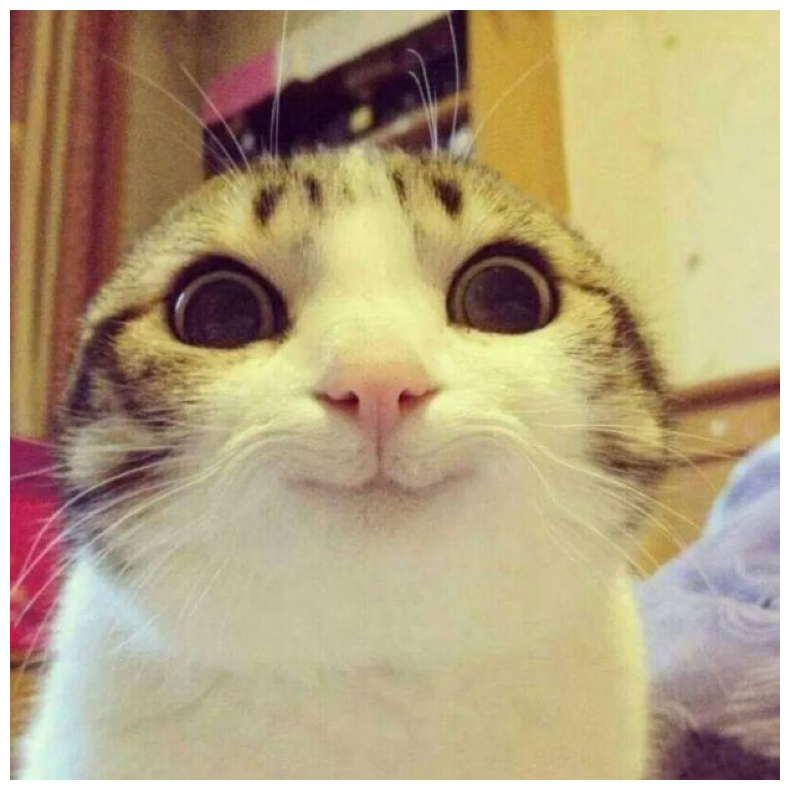


Predictions:
1. Label: Egyptian cat, Score: 0.6865
2. Label: tabby, tabby cat, Score: 0.1588
3. Label: tiger cat, Score: 0.1034
4. Label: lynx, catamount, Score: 0.0124
5. Label: Siamese cat, Siamese, Score: 0.0053


In [5]:
# Set up the image classification pipeline
vit_model_name = "google/vit-base-patch16-224"
image_classifier = pipeline("image-classification", model=vit_model_name)

# Classify an image
image_url_vit = "https://imgflip.com/s/meme/Smiling-Cat.jpg" #@param {type:"string"} # Example: Cat

# Display the image
_ = display_image(image_url_vit)

# Get predictions
predictions = image_classifier(image_url_vit)

print("\nPredictions:")
for i, pred in enumerate(predictions):
    print(f"{i+1}. Label: {pred['label']}, Score: {pred['score']:.4f}")

#### **Self-Supervised Learning (SSL)**
Enabling models to learn from vast unlabeled image datasets.

Create a "pretext task" where the model learns to predict some property of the data from other parts of the data, without human labels.

**Contrastive Learning:** It "pulls" representations of similar images (positive pairs: augmented views of an image) together and "pushes" representations of dissimilar images (negative pairs) apart.

SSL helps ViTs and other architectures learn robust visual representations, often leading to better performance when fine-tuned on downstream tasks with limited labeled data.

## **Section 3: Fusing Vision and Language - The Dawn of VLMs (CLIP)**

### **Connecting Pixels and Words**
So far, we've looked at models that understand images (like ResNet, ViT) and models that understand text (like Transformers). The next big step is to create models that can understand both and, more importantly, understand the relationship between them.

### **The CLIP Revolution**
Instead of traditional supervised learning on manually labeled datasets (e.g., ImageNet categories), CLIP learns from the vast amount of (image, text) pairs available on the internet.

Given a batch of images and a batch of text snippets, predict which image goes with which text.

#### **Contrastive Pre-training:**
<center>
<img src="https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png"/>

*(Image: CLIP pre-training and zero-shot classification - Source: OpenAI CLIP GitHub)*

</center>

**Encoders:**
- An Image Encoder (e.g., a ResNet or a Vision Transformer) to get image features.
- A Text Encoder (e.g., a Transformer) to get text features.
- Joint Embedding Space: Both encoders project their outputs into a shared multi-modal embedding space.

**Contrastive Loss:**

For a given batch of $N$ (image, text) pairs, the model calculates the cosine similarity between all possible image embeddings and text embeddings.

The training objective is to maximize the similarity for the $N$ correct (image, text) pairs and minimize the similarity for the $N \times N - N$ incorrect pairs. This is done using a symmetric cross-entropy loss over the similarity scores.



#### **Hands-on: Zero-Shot Image Classification with CLIP**
Let's use a pre-trained CLIP model from Hugging Face. We'll first explore its components and then use it for zero-shot image classification.

In [6]:
# Load a pre-trained CLIP model and its processor
clip_model_name = "openai/clip-vit-base-patch32"

model_clip = CLIPModel.from_pretrained(clip_model_name)
processor_clip = CLIPProcessor.from_pretrained(clip_model_name)
print(f"CLIP model and processor ('{clip_model_name}') loaded successfully.")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP model and processor ('openai/clip-vit-base-patch32') loaded successfully.


In [7]:
model_clip

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

Classifying image from: https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg


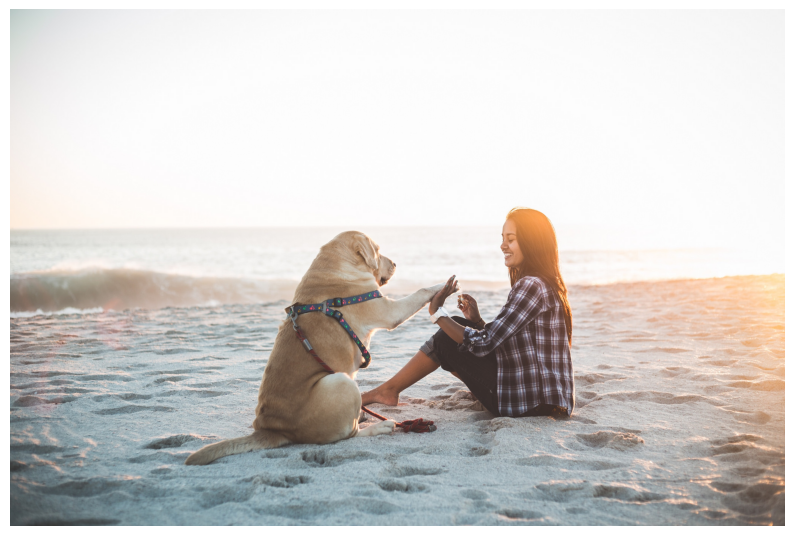


--- CLIP Zero-Shot Classification Results ---
Label: 'a photo of a cat', Probability: 0.0050
Label: 'a photo of a dog', Probability: 0.3512
Label: 'a photo of a person on a beach', Probability: 0.6437
Label: 'a drawing of a car', Probability: 0.0000
Label: 'a landscape with mountains', Probability: 0.0001

Best matching label: 'a photo of a person on a beach' with probability 0.6437


In [8]:
image_url_clip = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg" #@param {type:"string"}

# Candidate text labels for classification
text_labels = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a person on a beach",
    "a drawing of a car",
    "a landscape with mountains"
]

# Display the image
print(f"Classifying image from: {image_url_clip}")
pil_image_clip = display_image(image_url_clip)

# Preprocess the image and text
# The processor handles tokenization for text and image transformations for the vision part.
inputs_clip = processor_clip(
    text=text_labels,
    images=pil_image_clip,
    return_tensors="pt", # PyTorch tensors
    padding=True # ensures all text inputs are padded to the same length
)

# Perform inference to get embeddings and then logits
with torch.no_grad():
    outputs_clip = model_clip(**inputs_clip)
    # The logits_per_image gives the cosine similarities between the image embedding and each text embedding, scaled by the learned temperature.
    logits_per_image = outputs_clip.logits_per_image

# Get probabilities by applying softmax to the logits
probs = logits_per_image.softmax(dim=1) # Softmax over the text labels

print("\n--- CLIP Zero-Shot Classification Results ---")
# Print probabilities for each label
for i, label in enumerate(text_labels):
    print(f"Label: '{label}', Probability: {probs[0, i].item():.4f}")

# Find the label with the highest probability
best_label_idx = probs.argmax(-1).item()
print(f"\nBest matching label: '{text_labels[best_label_idx]}' with probability {probs[0, best_label_idx].item():.4f}")

Classifying image from: https://www.shutterstock.com/image-photo/wicker-basket-oranges-apples-on-600nw-1778587703.jpg


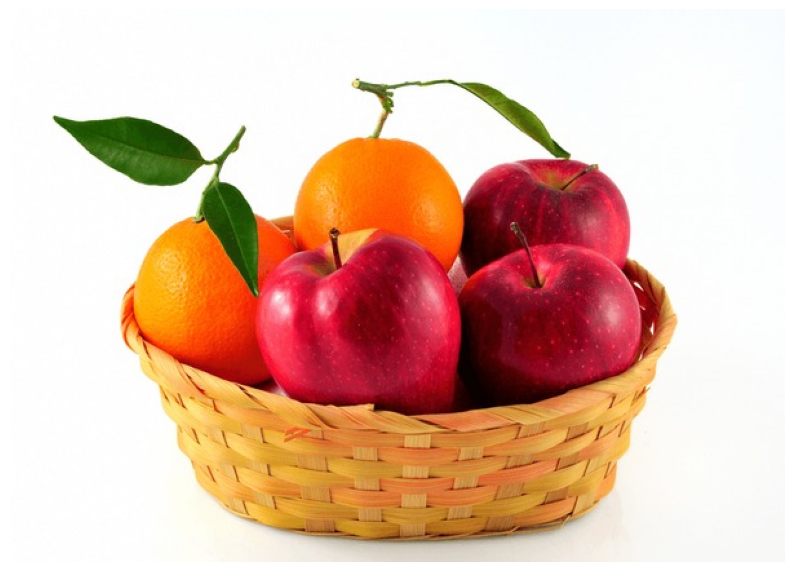


--- CLIP Zero-Shot Classification Results ---
Label: 'basket with 2 oranges and 3 apples', Probability: 0.4853
Label: 'basket with 3 oranges and 2 apples', Probability: 0.5147

Best matching label: 'basket with 3 oranges and 2 apples' with probability 0.5147


In [9]:
image_url_clip = "https://www.shutterstock.com/image-photo/wicker-basket-oranges-apples-on-600nw-1778587703.jpg" #@param {type:"string"}

# text labels for classification
text_labels = [
    "basket with 2 oranges and 3 apples",
    "basket with 3 oranges and 2 apples"
]

print(f"Classifying image from: {image_url_clip}")
pil_image_clip = display_image(image_url_clip)

# The processor handles tokenization for text and image transformations for the vision part.
inputs_clip = processor_clip(
    text=text_labels,
    images=pil_image_clip,
    return_tensors="pt", # PyTorch tensors
    padding=True # ensures all text inputs are padded to the same length
)

# Perform inference to get embeddings and then logits
with torch.no_grad():
    outputs_clip = model_clip(**inputs_clip)
    # The logits_per_image gives the cosine similarities between the image embedding and each text embedding, scaled by the learned temperature.
    logits_per_image = outputs_clip.logits_per_image

# Get probabilities by applying softmax to the logits
probs = logits_per_image.softmax(dim=1) # Softmax over the text labels

print("\n--- CLIP Zero-Shot Classification Results ---")
# Print probabilities for each label
for i, label in enumerate(text_labels):
    print(f"Label: '{label}', Probability: {probs[0, i].item():.4f}")

# Find the label with the highest probability
best_label_idx = probs.argmax(-1).item()
print(f"\nBest matching label: '{text_labels[best_label_idx]}' with probability {probs[0, best_label_idx].item():.4f}")

#### **SPARC: Learning Language Grouped Vision Embeddings**
This allows for better localization!
<center>
<img src = "https://drive.google.com/uc?export=view&id=1R70V82yWS9BUGJHB0IwbjbneTQDooS6p"
</center>

## **Section 4: The Rise of Powerful End-to-End VLMs**

### **4.1 Understanding How VLMs Fuse Vision and Language**

<center>
<img src = "https://drive.google.com/uc?export=view&id=1ostq7GmwkA45ONb20zaK0ahJdO5C0gEC">
</center>

#### **Early Fusion**
Combine the visual and textual inputs (or their low-level embeddings) at an early stage. This combined representation is then fed through a single, shared encoder (often a Transformer) that processes both modalities jointly.

Allows for rich, deep interaction between vision and language information from the very first layers.

Can be computationally intensive as the shared encoder processes a longer combined sequence. Less modularity compared to separate encoders.

#### **Hybrid Fusion / Cross-Attention**
Image and text are initially processed by separate "uni-modal" encoder streams.

Then, specialized cross-attention layers are introduced where information from one modality can attend to the other.

Offers a good balance and allows modalities to develop their own initial representations but enables fine-grained interaction where needed.

Can still be complex to design and train effectively.

#### **Late Fusion**
Process the image and text through entirely separate encoders. The resulting high-level embeddings are then combined at the very end.

Computationally efficient for tasks like retrieval, as image and text features can be pre-computed.

The model can't perform fine-grained reasoning that requires looking at specific parts of the image in conjunction with specific words early in the processing.

### **4.3 Introducing Qwen2.5-VL & Visual Instruction Tuning**


#### **Visual Instruction Tuning**
This technique adapts instruction tuning (popular in LLMs) to the multimodal domain. The core challenge is obtaining high-quality instruction-following data for vision and language. LLaVA demonstrated an innovative method to generate multimodal language-image instruction-following data.
- Visual content from images (e.g., captions, object bounding boxes with labels) was converted into a textual format.

- This textual representation was then fed to the language-only GPT-4 along with carefully designed prompts asking it to generate various instruction-response pairs (e.g., conversations about the image, detailed descriptions, or complex reasoning questions and answers based on the textual description of the image).

- This dataset of (original image, generated instruction, generated response) triplets was then used to fine-tune a Large Multimodal Model (LLaVA itself, which combines a vision encoder with an LLM like Vicuna). This process teaches the LMM to follow human-like instructions in a visual context.

#### **Standard VLM architecutre diagram**

<center>
<img src = "https://drive.google.com/uc?export=view&id=1C4UN5jh8YlZuimhFFr9KgUR0P4lmoQbp" width = "500">
</center>

#### **Qwen2.5-VL**
The Qwen series represents powerful, open-source LMMs, and Qwen2.5-VL is its latest flagship vision-language model, demonstrating significant advancements.

For our tutorial, we'll be demonstrating its zero-shot capabilities and then fine-tuning it for specific tasks. For efficient use in Colab, we'll use quantized version via Unsloth.


### **4.4 Zero-Shot with Qwen2.5-VL**
*Note: Running the cell below will download the Qwen2.5-VL model and its tokenizer. This can take a few minutes. Unsloth handles the complexities of 4-bit quantization for us.*

In [10]:
# Specify the Unsloth Qwen2.5-VL model
qwen_model_name_unsloth = "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit" #quantization

print(f"Loading Qwen2.5-VL model with Unsloth: {qwen_model_name_unsloth}.")

# Load model and tokenizer using Unsloth
model_qwen, tokenizer_qwen = FastVisionModel.from_pretrained(
    model_name=qwen_model_name_unsloth,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

print("Qwen2.5-VL model and tokenizer loaded successfully with Unsloth.")

Loading Qwen2.5-VL model with Unsloth: unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit.
==((====))==  Unsloth 2025.5.9: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Qwen2.5-VL model and tokenizer loaded successfully with Unsloth.


In [11]:
def run_inference(image, instruction, model, tokenizer):
    FastVisionModel.for_inference(model) # Enable for inference!

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    # Capture the output tokens
    output_tokens = model.generate(
        **inputs,
        max_new_tokens=512,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

    # Decode the tokens to get the text output
    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    # Remove the prompt part
    prompt_length = len(tokenizer.decode(inputs.input_ids[0], skip_special_tokens=True))
    generated_text = output_text[prompt_length:]

    return generated_text

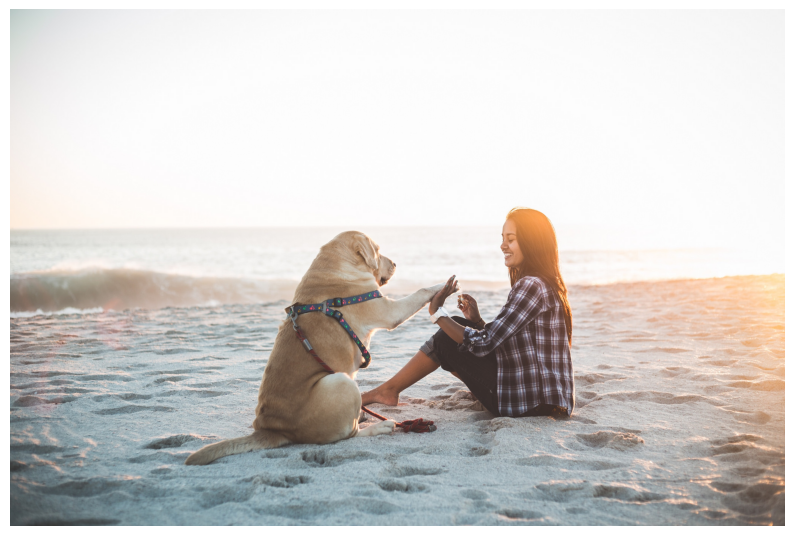


Caption: The image captures a serene beach scene featuring a woman and a dog on a sunny day. The woman is sitting on the sandy shore, smiling warmly as she interacts with the yellow labrador retriever beside her. The dog, wearing a harness adorned with colorful studs, has its front legs extended forward in what appears to be a gesture of affection or training. The sand under their feet is light-colored and slightly wet near the water's edge. In the background, the horizon line is visible, blending seamlessly into the vast ocean, which gently washes onto the shore. The sun is casting a warm glow on the scene, highlighting the happiness and connection between the two subjects.


In [12]:
# Task 1: Image Captioning
caption_image_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg" #@param {type:"string"}
caption_image = display_image(caption_image_url)

caption_instruction = 'Describe this image in detail.' #@param {type:"string"}

response_caption_qwen = run_inference(caption_image, caption_instruction, model_qwen, tokenizer_qwen)

print(f"\nCaption: {response_caption_qwen}")

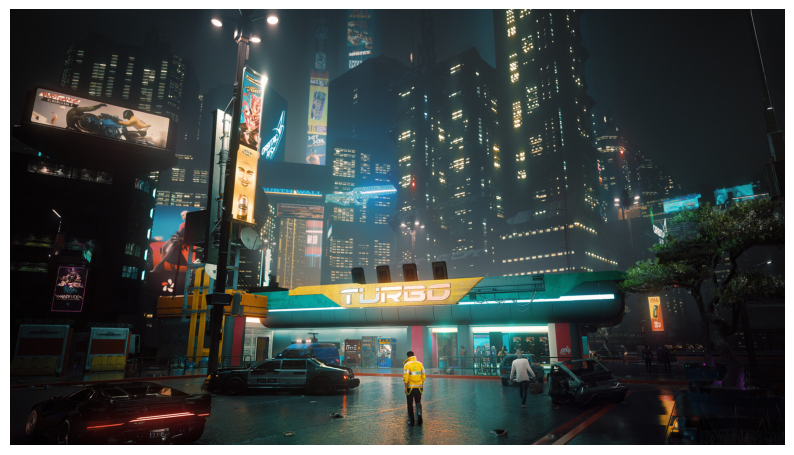


Answer: This image is from the video game Cyberpunk 2077. It showcases a night-time urban environment with neon lights and various billboards, which are characteristic of the game's cyberpunk aesthetic. The scene features a cityscape with towering buildings and a bustling street atmosphere.


In [13]:
# Task 2: Visual Question Answering
vqa_image_url = "https://shared.fastly.steamstatic.com/store_item_assets/steam/apps/1091500/ss_872822c5e50dc71f345416098d29fc3ae5cd26c1.1920x1080.jpg?t=1746519355" #@param {type:"string"}
vqa_image = display_image(vqa_image_url)

question_vqa_qwen = "Where is this image from?" #@param {type:"string"}

response_vqa_qwen = run_inference(vqa_image, question_vqa_qwen, model_qwen, tokenizer_qwen)

print(f"\nAnswer: {response_vqa_qwen}")

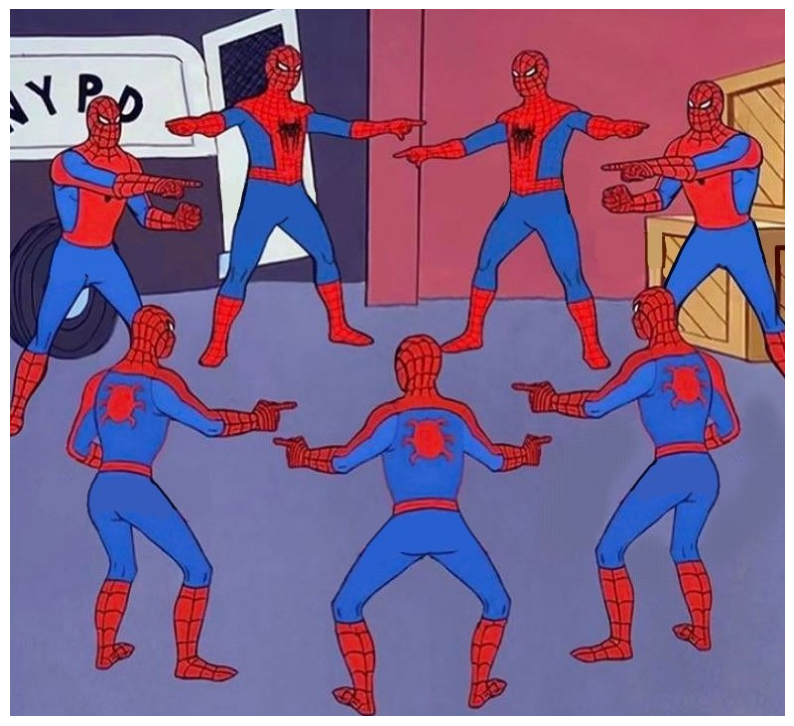


Answer: There are seven Spider-Men in the image, standing in front of an NYPD vehicle.


In [14]:
# Task 3: A slightly more complex query (can involve reasoning or grounding)
complex_image_url = "https://i.imgflip.com/5auep0.png?a485784" #@param {type:"string"}
complex_image = display_image(complex_image_url)

complex_query_qwen = "How many spidermen are there in this image?" #@param {type:"string"}

response_complex_qwen = run_inference(complex_image, complex_query_qwen, model_qwen, tokenizer_qwen)

print(f"\nAnswer: {response_complex_qwen}")

## **Section 5: Fine-tuning VLMs for Specialized Tasks - Object Detection Demo**

### **5.1 Dataset: Circuit Components**
For this demo, we'll use the "Circuit Voltages" dataset.

In [15]:
dataset_gdrive_url = "https://drive.google.com/uc?export=download&id=1DyFVSS3SWHRdQMlcQ2MiZKZB6Lpy0lOk"
dataset_zip_name = "circuit_voltages_coco.zip"
dataset_name = "circuit_voltages_dataset"

if os.path.exists(dataset_name) and os.path.exists(os.path.join(dataset_name, "train", "_annotations.coco.json")):
    print(f"Dataset already found!'. Skipping download and extraction.")
else:
    gdown.download(dataset_gdrive_url, dataset_zip_name, quiet=False)

    with zipfile.ZipFile(dataset_zip_name, 'r') as zip_ref:
      zip_ref.extractall("./")

    os.remove(dataset_zip_name)

# Define paths for the dataset
TRAIN_IMAGES_DIR = os.path.join(dataset_name, "train")
TRAIN_ANNOTATIONS_PATH = os.path.join(dataset_name, "train", "_annotations.coco.json")

TEST_IMAGES_DIR = os.path.join(dataset_name, "test")
TEST_ANNOTATIONS_PATH = os.path.join(dataset_name, "test", "_annotations.coco.json")

Downloading...
From: https://drive.google.com/uc?export=download&id=1DyFVSS3SWHRdQMlcQ2MiZKZB6Lpy0lOk
To: /content/circuit_voltages_coco.zip
100%|██████████| 9.22M/9.22M [00:00<00:00, 202MB/s]


In [16]:
def load_coco_annotations_intermediate(image_dir, annotation_path):
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)

    images_info = {img['id']: img for img in coco_data['images']}
    cat_id_to_name = {cat['id']: str(cat['name']) for cat in coco_data['categories']} # Ensure names are strings

    # Extract unique class names
    class_names = sorted(list(set(cat_id_to_name.values())))

    intermediate_data = []

    for img_id, img_details in images_info.items():
        image_filename = img_details['file_name']
        image_path = os.path.join(image_dir, image_filename)

        original_w = img_details['width']
        original_h = img_details['height']

        current_image_annotations = []
        for ann in coco_data['annotations']:
            if ann['image_id'] == img_id:
                coco_bbox = ann['bbox']  # COCO format: [x, y, width, height]
                category_name = cat_id_to_name[ann['category_id']]

                # Convert COCO bbox to absolute pixel [xmin, ymin, xmax, ymax]
                xmin = coco_bbox[0]
                ymin = coco_bbox[1]
                xmax = coco_bbox[0] + coco_bbox[2]
                ymax = coco_bbox[1] + coco_bbox[3]

                current_image_annotations.append({
                    "bbox_2d": [int(xmin), int(ymin), int(xmax), int(ymax)], # Ensure integer coordinates
                    "label": category_name
                })

        intermediate_data.append({
            "image_path": image_path,
            "width": original_w,
            "height": original_h,
            "annotations": current_image_annotations
        })

    return intermediate_data, class_names

intermediate_train_data, dataset_class_names = load_coco_annotations_intermediate(
    TRAIN_IMAGES_DIR,
    TRAIN_ANNOTATIONS_PATH
)

intermediate_test_data, _ = load_coco_annotations_intermediate(
    TEST_IMAGES_DIR,
    TEST_ANNOTATIONS_PATH
)

In [17]:
def format_annotations_for_assistant_message(annotations: list[dict]) -> str:
    detection_lines = []
    for ann in annotations:
        label = ann["label"]
        # Ensure all elements in bbox_2d are converted to string for join
        bbox_str = ", ".join(map(str, ann["bbox_2d"]))
        line = f'\t{{"bbox_2d": [{bbox_str}], "label": "{label}"}}'
        detection_lines.append(line)

    joined_detections = ",\n".join(detection_lines)
    # Wrap the JSON array in markdown code block for JSON
    formatted_str = f"```json\n[\n{joined_detections}\n]\n```"
    return formatted_str

def convert_to_conversation(intermediate_sample):
    image_path = intermediate_sample["image_path"]
    annotations = intermediate_sample["annotations"]

    user_instruction = f"Identify and locate all {', '.join(dataset_class_names)}. Provide bounding boxes in JSON format."

    # Load the image
    pil_image = Image.open(image_path).convert("RGB")

    # Format annotations for the assistant's response
    assistant_content_json_string = format_annotations_for_assistant_message(annotations)

    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_instruction},
                    {"type": "image", "image": pil_image}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": assistant_content_json_string}
                ]
            }
        ]
    }


unsloth_train_dataset = [convert_to_conversation(sample) for sample in intermediate_train_data]
unsloth_test_dataset = [convert_to_conversation(sample) for sample in intermediate_test_data]

In [18]:
unsloth_test_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Identify and locate all Ground, Input DC, Isolated Input DC, Isolated Voltage DC, Resistor, Voltage DC, circuit-symbols. Provide bounding boxes in JSON format.'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1336x691>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '```json\n[\n\t{"bbox_2d": [582, 108, 758, 172], "label": "Resistor"},\n\t{"bbox_2d": [267, 278, 400, 439], "label": "Voltage DC"},\n\t{"bbox_2d": [614, 518, 738, 574], "label": "Resistor"},\n\t{"bbox_2d": [1061, 555, 1167, 626], "label": "Ground"}\n]\n```'}]}]}

### **Section 5.2: Why Finetune?**

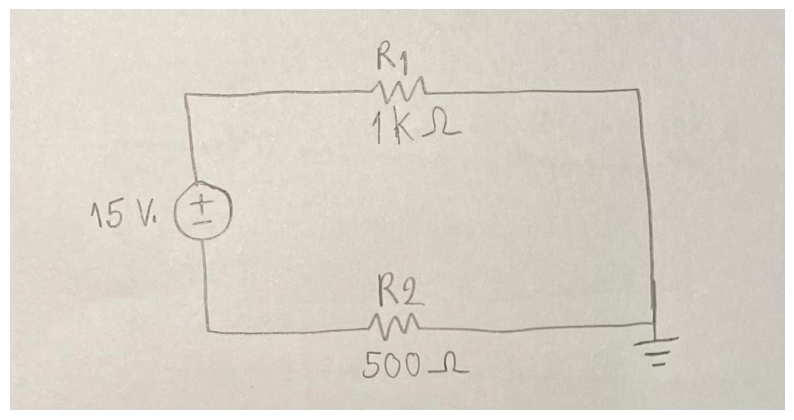


Zero-Shot Generated JSON Output:
```json
[
	{"bbox_2d": [409, 147, 421, 237], "label": "Ground"},
	{"bbox_2d": [8, 6, 1314, 552], "label": "circuit-symbols"}
]
```


In [19]:
zero_shot_prompt = unsloth_test_dataset[0]['messages'][0]['content'][0]['text']

# Take the first image from the designated test/sample split
test_image = unsloth_test_dataset[0]['messages'][0]['content'][1]['image']
display_image(test_image)

test_out = run_inference(test_image, zero_shot_prompt, model_qwen, tokenizer_qwen)
print("\nZero-Shot Generated JSON Output:")
print(test_out)

In [20]:
def parse_bbox(output):
  try:
    # Remove the markdown code block delimiters and "json" identifier
    json_string = output.strip("`\n").removeprefix("json\n")

    # Parse the JSON string
    parsed_output = json.loads(json_string)

    return parsed_output

  except:
    print(f"Cannot parse: {output}")
    return []

detected_objects_info_zs = parse_bbox(test_out)
for obj in detected_objects_info_zs:
  print(f" - Label: {obj.get('label', 'N/A')}, BBox: {obj.get('bbox_2d', 'N/A')}")

 - Label: Ground, BBox: [409, 147, 421, 237]
 - Label: circuit-symbols, BBox: [8, 6, 1314, 552]


In [21]:
def parse_parsed_json_to_sv_detections(detected_objects, available_class_names):
    if not detected_objects:
        return sv.Detections.empty()

    class_to_id_map = {name: i for i, name in enumerate(available_class_names)}
    boxes_xyxy = []
    class_ids = []

    for obj in detected_objects:
        bbox = obj["bbox_2d"]
        label_str = str(obj.get("label", ""))

        boxes_xyxy.append([float(coord) for coord in bbox])
        class_ids.append(class_to_id_map[label_str])

    if not boxes_xyxy:
        return sv.Detections.empty()

    return sv.Detections(xyxy=np.array(boxes_xyxy), class_id=np.array(class_ids))

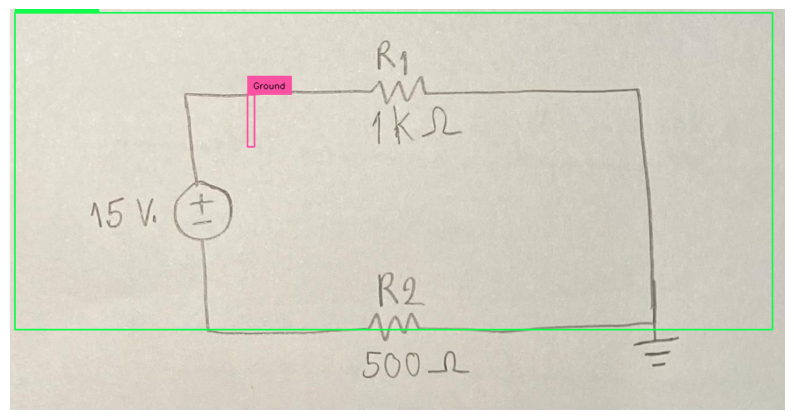

In [22]:
def annotate_image(image, detections, dataset_class_names):
    box_annotator = sv.BoxAnnotator(thickness=2)
    detection_labels = [
        f"{dataset_class_names[class_id]}"
        for class_id in detections.class_id
    ]
    label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5, text_color=sv.Color.BLACK)

    annotated_image_np = np.array(image)
    annotated_image_np = box_annotator.annotate(scene=annotated_image_np, detections=detections)
    annotated_image_np = label_annotator.annotate(scene=annotated_image_np, detections=detections, labels=detection_labels)
    annotated_pil_image = Image.fromarray(annotated_image_np)

    return annotated_pil_image

# Convert the output of your parse_bbox function to sv.Detections
zero_shot_detections = parse_parsed_json_to_sv_detections(
    detected_objects_info_zs,
    dataset_class_names
)

_ = display_image(annotate_image(test_image, zero_shot_detections, dataset_class_names))

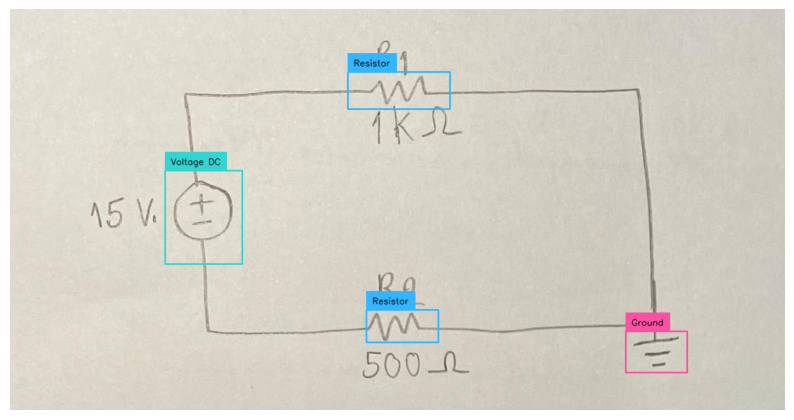

In [23]:
gt_json = parse_bbox(unsloth_test_dataset[0]['messages'][1]['content'][0]['text'])
gt_sv = parse_parsed_json_to_sv_detections(gt_json, dataset_class_names)
_ = display_image(annotate_image(test_image, gt_sv, dataset_class_names))

### **Section 5.3: Finetuning!**

In [24]:
# Add LoRA adapters for parameter-efficient finetuning
model_qwen = FastVisionModel.get_peft_model(
    model_qwen,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=8,                # LoRA rank
    lora_alpha=16,       # Alpha for scaling LoRA weights
    lora_dropout=0.05,      # Dropout probability for LoRA layers
    bias="none",         # Bias type for LoRA. "none" is common.
    random_state=3407,   # For reproducibility
    use_rslora=False,    # Rank Stabilized LoRA
    loftq_config=None,   # LoftQ configuration
)

# Enable training mode for the PEFT model
FastVisionModel.for_training(model_qwen)

# This collator handles the specifics of padding and preparing batches for vision models
data_collator = UnslothVisionDataCollator(model_qwen, tokenizer_qwen)

# Define Training Arguments (SFTConfig)
training_args = SFTConfig(
    output_dir="qwen_circuit_finetune_outputs", # Directory to save checkpoints and logs
    per_device_train_batch_size=4,  # Adjust based on your GPU VRAM. Start small.
    gradient_accumulation_steps=1,  # Effective batch size = batch_size * accumulation_steps
    warmup_steps=5,                 # Number of steps for learning rate warmup
    num_train_epochs=5,             # Number of epochs.
    learning_rate=2e-4,             # Learning rate
    logging_steps=5,                # Log training progress every X steps
    optim="adamw_8bit",             # Optimizer. adamw_8bit is memory efficient.
    weight_decay=0.01,
    lr_scheduler_type="linear",     # Learning rate scheduler
    seed=3407,                      # For reproducibility

    # Mixed precision training
    fp16=not torch.cuda.is_bf16_supported(), # Use fp16 if bf16 is not supported
    bf16=torch.cuda.is_bf16_supported(),     # Use bf16 if supported (newer GPUs)

    # Crucial for Unsloth vision finetuning with "messages" format:
    remove_unused_columns=False,    # Important for custom datasets
    dataset_text_field="",          # Unsloth handles this internally when "messages" are present
    dataset_kwargs={"skip_prepare_dataset": True}, # Skip Hugging Face's automatic dataset prep
    dataset_num_proc=2,             # Number of processes for dataset mapping (adjust based on CPU)
    max_seq_length=1024,            # Max sequence length (prompt + completion). Adjust if needed.

    # Reporting
    report_to="none",  # Can be "wandb", "tensorboard", etc.
)

# Initialize the SFTTrainer
trainer = SFTTrainer(
    model=model_qwen,          # The PEFT-enabled model
    tokenizer=tokenizer_qwen,
    train_dataset=unsloth_train_dataset, # Your prepared dataset
    data_collator=data_collator,    # The Unsloth vision data collator
    args=training_args,
)


# Start training
trainer_stats = trainer.train()
print(f"Training statistics: {trainer_stats}")

# Save the fine-tuned LoRA adapters
lora_output_dir = "qwen_circuit_lora_adapters"
model_qwen.save_pretrained(lora_output_dir)
tokenizer_qwen.save_pretrained(lora_output_dir) # Save tokenizer with adapters

# You can also push to Hub if you want:
# model_qwen_peft.push_to_hub("your_username/your_model_name", token="YOUR_HF_TOKEN")
# tokenizer_qwen.push_to_hub("your_username/your_model_name", token="YOUR_HF_TOKEN")

del trainer
del model_qwen
gc.collect()
torch.cuda.empty_cache()
gc.collect()

Unsloth: Model does not have a default image size - using 512


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 92 | Num Epochs = 5 | Total steps = 115
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 20,542,464/3,000,000,000 (0.68% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!
Training statistics: TrainOutput(global_step=115, training_loss=0.6181858187136443, metrics={'train_runtime': 499.3905, 'train_samples_per_second': 0.921, 'train_steps_per_second': 0.23, 'total_flos': 4685213108502528.0, 'train_loss': 0.6181858187136443})


86130

In [25]:
model_qwen_test, tokenizer_qwen_test = FastVisionModel.from_pretrained(
    model_name = lora_output_dir,
    load_in_4bit = True,
    device_map="auto"
)

==((====))==  Unsloth 2025.5.9: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [26]:
finetune_test_out = run_inference(test_image, zero_shot_prompt, model_qwen_test, tokenizer_qwen_test)
print("\nFinetune Generated JSON Output:")
print(finetune_test_out)


Finetune Generated JSON Output:
```json
[
	{"bbox_2d": [641, 511, 717, 607], "label": "Resistor"},
	{"bbox_2d": [623, 918, 726, 1069], "label": "Resistor"},
	{"bbox_2d": [441, 333, 616, 507], "label": "Voltage DC"}
]
```


In [27]:
detected_objects_info_ft = parse_bbox(finetune_test_out)
for obj in detected_objects_info_ft:
  print(f" - Label: {obj.get('label', 'N/A')}, BBox: {obj.get('bbox_2d', 'N/A')}")

 - Label: Resistor, BBox: [641, 511, 717, 607]
 - Label: Resistor, BBox: [623, 918, 726, 1069]
 - Label: Voltage DC, BBox: [441, 333, 616, 507]


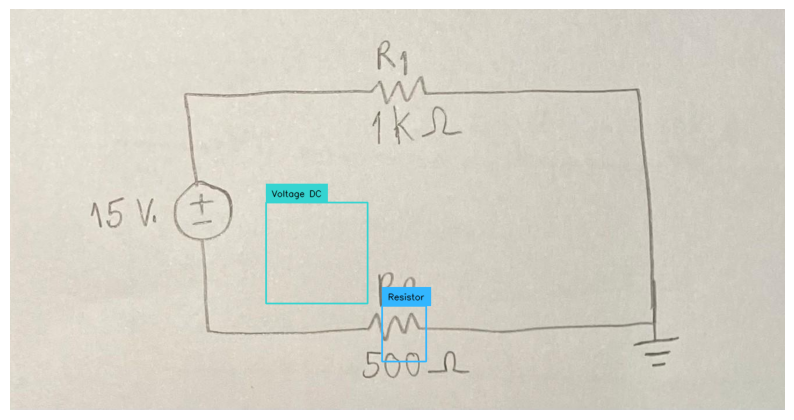

In [28]:
# Convert the output of your parse_bbox function to sv.Detections
ft_detections = parse_parsed_json_to_sv_detections(
    detected_objects_info_ft,
    dataset_class_names
)

_ = display_image(annotate_image(test_image, ft_detections, dataset_class_names))

In [29]:
del model_qwen_test
del tokenizer_qwen_test
gc.collect()
torch.cuda.empty_cache()
gc.collect()

84374

## **Section 6: Fine-tuning VLMs - OCR Exercise**

In [30]:
# Specify the Unsloth Qwen2.5-VL model
qwen_model_name_unsloth = "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit"

# Load model and tokenizer using Unsloth
model, tokenizer = FastVisionModel.from_pretrained(
    model_name=qwen_model_name_unsloth,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

==((====))==  Unsloth 2025.5.9: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

We can also finetune
- ONLY the vision part of the model, or
- ONLY the language part or
- both vision and language part or
- the attention or the MLP layers

In [31]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

<a name="Data"></a>
### Data Prep
We'll be using a sampled dataset of handwritten maths formulas. The goal is to convert these images into a computer readable form - ie in LaTeX form, so we can render it. This can be very useful for complex formulas.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [33]:
import gdown
file_id = "1v2wjHkLigwzRiE1m2I8TOz3542YjW1qA"
gdown.download(f"https://drive.google.com/uc?id={file_id}", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1v2wjHkLigwzRiE1m2I8TOz3542YjW1qA
From (redirected): https://drive.google.com/uc?id=1v2wjHkLigwzRiE1m2I8TOz3542YjW1qA&confirm=t&uuid=0c591e79-d576-48d5-99f2-1e4662def67e
To: /content/latex_ocr.zip

  0%|          | 0.00/362M [00:00<?, ?B/s]
  1%|▏         | 4.72M/362M [00:00<00:09, 39.5MB/s]
  4%|▍         | 14.2M/362M [00:00<00:05, 68.4MB/s]
  7%|▋         | 23.6M/362M [00:00<00:04, 79.1MB/s]
 10%|█         | 36.7M/362M [00:00<00:03, 96.3MB/s]
 14%|█▍        | 50.3M/362M [00:00<00:02, 109MB/s] 
 17%|█▋        | 61.9M/362M [00:00<00:02, 106MB/s]
 20%|██        | 72.9M/362M [00:00<00:02, 105MB/s]
 24%|██▍       | 87.0M/362M [00:00<00:02, 114MB/s]
 27%|██▋       | 98.6M/362M [00:00<00:02, 109MB/s]
 32%|███▏      | 115M/362M [00:01<00:01, 124MB/s] 
 35%|███▌      | 128M/362M [00:01<00:02, 108MB/s]
 39%|███▊      | 139M/362M [00:01<00:02, 107MB/s]
 42%|████▏     | 150M/362M [00:01<00:02, 103MB/s]
 45%|████▌     | 164M/362M [00:

'latex_ocr.zip'

In [34]:
!unzip latex_ocr.zip

Archive:  latex_ocr.zip
   creating: ocr_data/
  inflating: ocr_data/.DS_Store      
  inflating: ocr_data/train-00000-of-00001.parquet  
  inflating: ocr_data/test-00000-of-00001.parquet  


In [35]:
from datasets import load_dataset
dataset = load_dataset(
    "parquet",
    data_files="/content/ocr_data/train-00000-of-00001.parquet",
    split="train",
    verification_mode="no_checks",
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [36]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

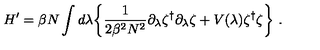

In [37]:
dataset[2]["image"]

In [38]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

Render the latex

In [39]:
from IPython.display import display, Math, Latex

latex = dataset[2]["text"]
display(Math(latex))

<IPython.core.display.Math object>

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q},
              {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [40]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [41]:
# convert the dataset into the "correct" format for finetuning
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [42]:
len(converted_dataset)

68686

In [43]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [45]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[1]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
latex_output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

decoded_output = tokenizer.batch_decode(latex_output)[0]

# Extract LaTeX content
start_tag = "<|im_start|>assistant\n"
end_tag = "<|im_end|>"
start_idx = decoded_output.find(start_tag)
end_idx = decoded_output.find(end_tag, start_idx + len(start_tag))

if start_idx != -1 and end_idx != -1:
    latex = decoded_output[start_idx + len(start_tag):end_idx].strip()
else:
    latex = decoded_output  # fallback in case tags aren't found

display(Math(latex))

$$\tilde { \partial } _ { \mu } ^ { \tilde \alpha \beta } { \tilde { A } } _ { \underline \mu } ^ { \beta } = 0 ,$$<|im_end|>


<IPython.core.display.Math object>

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer).

In [46]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 3, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


Start the training process

In [47]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928/3,000,000,000 (1.37% trained)


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [55]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

decoded_output = tokenizer.batch_decode(latex_output)[0]

# Extract LaTeX content
start_tag = "<|im_start|>assistant\n"
end_tag = "<|im_end|>"
start_idx = decoded_output.find(start_tag)
end_idx = decoded_output.find(end_tag, start_idx + len(start_tag))

if start_idx != -1 and end_idx != -1:
    latex = decoded_output[start_idx + len(start_tag):end_idx].strip()
else:
    latex = decoded_output  # fallback in case tags aren't found

display(Math(latex))

KeyError: 'https://www.google.com/imgres?q=wikipedia%20image&imgurl=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fen%2Fthumb%2F8%2F80%2FWikipedia-logo-v2.svg%2F1200px-Wikipedia-logo-v2.svg.png&imgrefurl=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FWikipedia&docid=xzLRoGhvtVjKpM&tbnid=Xc5PzAi6nr6FBM&vet=12ahUKEwiT75fs_NaNAxUFja8BHXFFIfkQM3oECB0QAA..i&w=1200&h=1096&hcb=2&ved=2ahUKEwiT75fs_NaNAxUFja8BHXFFIfkQM3oECB0QAA'

In [49]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

[]

In [50]:
del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [51]:
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True, # Set to False for 16bit LoRA
)
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
latex_output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)


==((====))==  Unsloth 2025.5.9: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
H ^ { \prime } = \beta N \int \mathrm { d } { \boldsymbol \lambda } , { \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } } \partial _ { \boldsymbol \lambda } \zeta ^ { i } \partial ^ { j } \zeta \xi ^ { i } \xi ^ { j } .<|im_end|>


In [52]:
tokenizer.batch_decode(latex_output)

['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|vision_end|>Write the LaTeX representation for this image.<|im_end|>\n<|im_start|>assistant\nH ^ { \\prime } = \\beta N \\int \\mathrm { d } { \\boldsymbol \\lambda } , { \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } } \\partial _ { \\boldsymbol \\lambda } \\zeta ^ { i } \\partial ^ { j } \\zeta \\xi ^ { i } \\xi ^ { j } .<|im_end|>']

In [53]:
decoded_output = tokenizer.batch_decode(latex_output)[0]

# Extract LaTeX content
start_tag = "<|im_start|>assistant\n"
end_tag = "<|im_end|>"
start_idx = decoded_output.find(start_tag)
end_idx = decoded_output.find(end_tag, start_idx + len(start_tag))

if start_idx != -1 and end_idx != -1:
    latex = decoded_output[start_idx + len(start_tag):end_idx].strip()
else:
    latex = decoded_output  # fallback in case tags aren't found

display(Math(latex))

<IPython.core.display.Math object>

## **Section 7: The Expanding VLM Universe & Ethical Considerations**

Beyond what we covered:
- Video VLMs (Qwen2.5-VL supports video).
- Multimodal Agents (models that can "act" based on visual input).

Ethical Considerations:
- Bias in datasets and models (leading to unfair or stereotypical outputs).
- Misinformation (deepfakes, generated content).
- Job displacement.
- Privacy (models trained on public/private data).
- Responsible development and deployment.

## **Section 8: Conclusion & Your VLM Journey Ahead**


Summary: "From Pixels & Words -> Transformers -> CLIP -> Powerful VLMs -> Fine-tuning for Specialization."

You've now seen the core evolution, used a state-of-the-art VLM, and even fine-tuned it!

Where to go next:
- Explore other models on Hugging Face.
- Try fine-tuning on larger, more complex datasets.
- Contribute to open-source VLM projects.

## **References**
### **Section 1**
LSTM: https://www.researchgate.net/publication/13853244_Long_Short-Term_Memory

Sequence to Sequence Learning with Neural Networks: https://arxiv.org/abs/1409.3215

Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation: https://arxiv.org/abs/1406.1078

Neural Machine Translation by Jointly Learning to Align and Translate: https://arxiv.org/abs/1409.0473

Attention Is All You Need: https://arxiv.org/abs/1706.03762

### **Section 2**
Deep Residual Learning for Image Recognition: https://arxiv.org/abs/1512.03385

An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale: https://arxiv.org/abs/2010.11929

Images from this blog: https://seantrott.substack.com/p/vision-language-models-vlms-explained

### **Section 3**
Learning Transferable Visual Models From Natural Language Supervision: https://arxiv.org/abs/2103.00020

Improving fine-grained understanding in image-text pre-training: https://arxiv.org/abs/2401.09865

### **Section 4**
Unsloth: https://docs.unsloth.ai/

Architecture from this blog: https://blog.ngxson.com/my-journey-in-vision-models

Qwen2.5-VL Technical Report: https://arxiv.org/abs/2502.13923

Circuit Voltages Data: https://universe.roboflow.com/roboflow-100/circuit-voltages/dataset/2/download

Supervision: https://supervision.roboflow.com/latest/

LaTeX_OCR Data : https://huggingface.co/datasets/unsloth/LaTeX_OCR/tree/main